<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/Best_Subset_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Best Subset Selection

In [3]:
hitters_df = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Hitters.csv')
hitters_df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


## Change the name of the first column

In [11]:

hitters_df=hitters_df.rename(columns={"Unnamed: 0":"Player"})

In [15]:
hitters_df.head()

,Player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


### Check the missing of some data column

In [4]:
print("Number of null values:", hitters_df['Salary'].isnull().sum())

Number of null values: 59


## Remove the missing values with dropna() function

In [13]:
# Print the dimension of original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the payer names
hitters_df_clean = hitters_df.dropna().drop('Player', axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print('Number of null values:', hitters_df_clean['Salary'].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


Extract some categorical predictors from table

In [18]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the fueature set X
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [19]:
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


### Perform best subset selection

In [28]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}


In [35]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [36]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 19 models on 1 predictors in 0.0652773380279541 seconds.
Processed 171 models on 2 predictors in 0.47344255447387695 seconds.
Processed 969 models on 3 predictors in 2.9735565185546875 seconds.
Processed 3876 models on 4 predictors in 12.202307224273682 seconds.
Processed 11628 models on 5 predictors in 37.31482410430908 seconds.
Processed 27132 models on 6 predictors in 90.06894946098328 seconds.
Processed 50388 models on 7 predictors in 175.67883610725403 seconds.
Total elapsed time: 320.5151832103729 seconds.


In [44]:
models_best

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...
5,2.718780e+07,<statsmodels.regression.linear_model.Regressio...
6,2.639772e+07,<statsmodels.regression.linear_model.Regressio...
7,2.606413e+07,<statsmodels.regression.linear_model.Regressio...


### Access to a specific model

In [45]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    5.80e-82
Time:                        07:30:15   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [46]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.018834352493286133 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    1.31e-76
Time:                        07:31:40   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P

In [49]:
models_best.loc[2, "model"].rsquared

0.7614950002332872

In [52]:
# Get the second element from each row ('model) and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

1    0.664637
2    0.761495
3    0.771757
4    0.782885
5    0.789008
6    0.795140
7    0.797728
dtype: float64

## Plot RSS, adjusted $R^2$, AIC, and BIC

Text(0, 0.5, 'BIC')

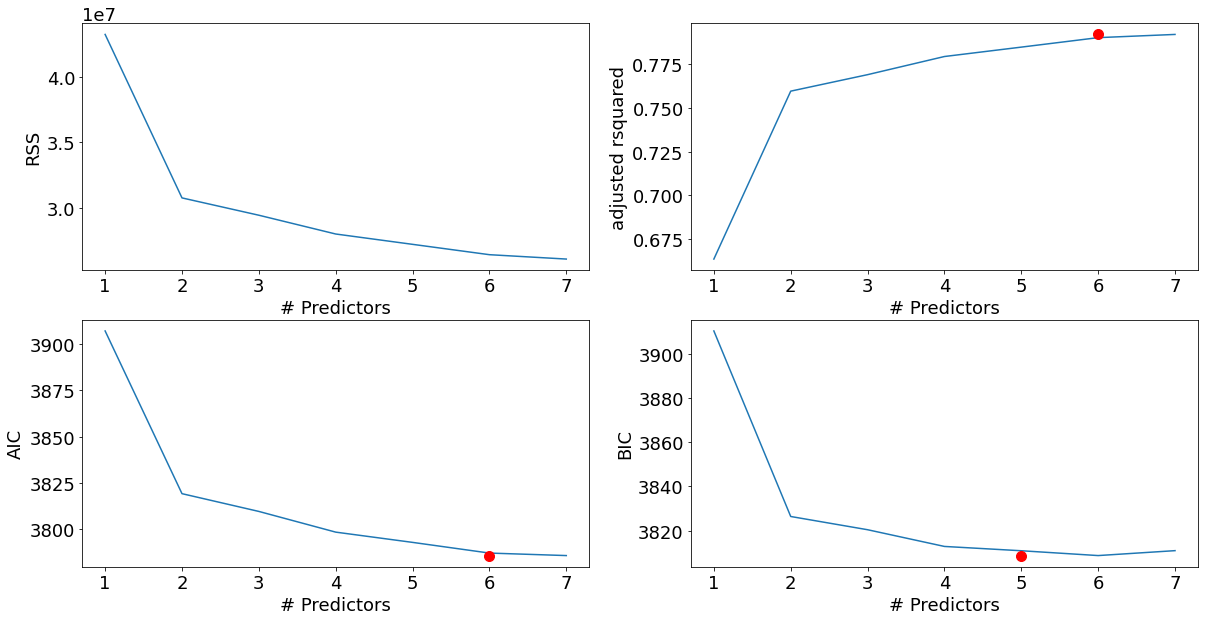

In [53]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

A model with 6 varibles is the best acording to AIC. According to AIC and adjusted  $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

## Forward and Backward Stepwise Selection

In [56]:
def forward(predictors):

  # Pull out predictors we still need to process
  ramaining_predictors = [p for p in X.columns if p not in predictors]

  tic = time.time()
  results = []

  for p in ramaining_predictors:
    results.append(processSubset(predictors + [p]))

  # Wrap everything up in a nice dataframe
  models = pd.DataFrame(results)

  # Choose the model with the highest RSS
  best_model = models.loc[models['RSS'].argmin()]

  toc = time.time()
  print('Processed', models.shape[0], 'models on', len(predictors)+1, 'predictors in', (toc-tic), 'seconds.')
  return best_model

Check the Forward method

In [57]:
models_fwd = pd.DataFrame(columns=['RSS', 'model'])
tic = time.time()
predictors = []

for i in range(1, len(X.columns) + 1):
  models_fwd.loc[i] = forward(predictors)
  predictors = models_fwd.loc[i]['model'].model.exog_names

toc = time.time()

print('Total elapse time:', (toc-tic),'seconds.')

Processed 19 models on 1 predictors in 0.06740808486938477 seconds.
Processed 18 models on 2 predictors in 0.06304478645324707 seconds.
Processed 17 models on 3 predictors in 0.058389902114868164 seconds.
Processed 16 models on 4 predictors in 0.05737805366516113 seconds.
Processed 15 models on 5 predictors in 0.06411552429199219 seconds.
Processed 14 models on 6 predictors in 0.0639791488647461 seconds.
Processed 13 models on 7 predictors in 0.05559992790222168 seconds.
Processed 12 models on 8 predictors in 0.05350613594055176 seconds.
Processed 11 models on 9 predictors in 0.08563947677612305 seconds.
Processed 10 models on 10 predictors in 0.0744478702545166 seconds.
Processed 9 models on 11 predictors in 0.05996584892272949 seconds.
Processed 8 models on 12 predictors in 0.07047843933105469 seconds.
Processed 7 models on 13 predictors in 0.051175594329833984 seconds.
Processed 6 models on 14 predictors in 0.04567980766296387 seconds.
Processed 5 models on 15 predictors in 0.025007

In [61]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.795
Model:                            OLS   Adj. R-squared (uncentered):              0.790
Method:                 Least Squares   F-statistic:                              166.3
Date:                Fri, 03 Sep 2021   Prob (F-statistic):                    1.79e-85
Time:                        08:09:28   Log-Likelihood:                         -1887.6
No. Observations:                 263   AIC:                                      3787.
Df Residuals:                     257   BIC:                                      3809.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Backward Selection

In [62]:
def backward(predictors):

  # Pull out predictors we still need to process
  #ramaining_predictors = [p for p in X.columns if p not in predictors]

  tic = time.time()
  results = []

  for combo in itertools.combinations(predictors, len(predictors)-1):
    results.append(processSubset(combo))

  # Wrap everything up in a nice dataframe
  models = pd.DataFrame(results)

  # Choose the model with the highest RSS
  best_model = models.loc[models['RSS'].argmin()]

  toc = time.time()
  print('Processed', models.shape[0], 'models on', len(predictors)+1, 'predictors in', (toc-tic), 'seconds.')
  return best_model

In [64]:
models_bwd = pd.DataFrame(columns=['RSS', 'model'], index = range(1, len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors)>1):
  models_bwd.loc[len(predictors)-1] = backward(predictors)
  predictors = models_bwd.loc[len(predictors)-1]['model'].model.exog_names

toc = time.time()

print('Total elapse time:', (toc-tic),'seconds.')

Processed 19 models on 20 predictors in 0.1202399730682373 seconds.
Processed 18 models on 19 predictors in 0.10021519660949707 seconds.
Processed 17 models on 18 predictors in 0.0966651439666748 seconds.
Processed 16 models on 17 predictors in 0.06502795219421387 seconds.
Processed 15 models on 16 predictors in 0.053488731384277344 seconds.
Processed 14 models on 15 predictors in 0.04804253578186035 seconds.
Processed 13 models on 14 predictors in 0.0755763053894043 seconds.
Processed 12 models on 13 predictors in 0.06361794471740723 seconds.
Processed 11 models on 12 predictors in 0.05710101127624512 seconds.
Processed 10 models on 11 predictors in 0.06824731826782227 seconds.
Processed 9 models on 10 predictors in 0.05844902992248535 seconds.
Processed 8 models on 9 predictors in 0.057961463928222656 seconds.
Processed 7 models on 8 predictors in 0.03155159950256348 seconds.
Processed 6 models on 7 predictors in 0.024949312210083008 seconds.
Processed 5 models on 6 predictors in 0.0

In [65]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

------------
Best Subset:
------------
Hits            1.680029
Walks           3.399961
CAtBat         -0.328835
CHits           1.347017
CHmRun          1.349373
PutOuts         0.248166
Division_W   -111.943760
dtype: float64


In [66]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

-----------------
Foward Selection:
-----------------
Hits            7.277149
CRBI            0.652415
Division_W   -110.656338
PutOuts         0.259787
AtBat          -1.644651
Walks           3.684324
League_N       49.978410
dtype: float64


In [67]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

-------------------
Backward Selection:
-------------------
AtBat         -1.601655
Hits           6.148449
Walks          5.866033
CRuns          1.097453
CWalks        -0.650614
PutOuts        0.310125
Division_W   -95.027171
dtype: float64
